## Setup

#### Libs







In [1]:
# Importing all required library
import re
import nltk
import cv2
import tweepy
import string
import numpy as np
import pandas as pd
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Important Functions

In [3]:
# stop words
stop_words = set(nltk.corpus.stopwords.words('english'))
stpwrd_punc = list(stop_words)+list(string.punctuation)

# functions to clean the tweets
def deEmojify(text):
    "function to remove emojis from text"
    regrex_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return regrex_pattern.sub('',text)

def cleanTxt(text, stop_words=stpwrd_punc):
    """Function to clean tweets, it will remove
       * Twitter mentions, hashtags, retweet tag, hyperlink
       * Stopwords
       * Emojis
       * Punctuations"""
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink

    # remove stop words emoji and punctuations
    stpwrd = stop_words
    word_tokens = nltk.word_tokenize(text) 
    filtered_text = ' '.join([deEmojify(word) for word in word_tokens if word not in stop_words])
    return filtered_text

def getSubjectivity(text):
    """This function return the subjectivity of
        tweets"""
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    """This function return the polarity of
        tweets"""
    return  TextBlob(text).sentiment.polarity

def getAnalysis(score):
    """A function to classify tweets as 
       negative, neutral and positive
       based on polarity """
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

def Word_cloud(data, stop_words, figsize=(20, 12), mask=None):
    """This function will create wordcloud"""
    Cloud = WordCloud(scale=3,
                      random_state=21,
                      colormap='Greys',
                      mask=mask,
                      stopwords=stop_words,
                      collocations=True,).generate(data)
    plt.figure(figsize=figsize)
    # Cloud.to_file(str(title)+'.png')  #uncomment this if you want to download it
    plt.imshow(Cloud)
    plt.axis('off')
    plt.show() 

#### API verification

To extracts the tweets from twitter, you will need to have an API, which you can get by creating an APP on [twitter developer](https://apps.twitter.com/).






In [4]:
# Load the data
from google.colab import files
# uploaded = files.upload()

Now you need to put your all credentianls of API here, in order to connect it with twitter, so let's do that here

In [5]:
# Get the data
log = pd.read_csv("Twitter API.csv")

# Twitter Api Credentials
consumerKey = log.Consumer_Key[0]
consumerSecret = log.Consumer_Secret[0]
accessToken = log.Acess_Token[0]
accessTokenSecret = log.Acess_Secret[0]

We will use tweepy to authenticate and connect with twitter

In [6]:
# Create the authentication object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret) 
    
# Set the access token and access token secret
authenticate.set_access_token(accessToken, accessTokenSecret) 
    
# Creating the API object while passing in auth information
api = tweepy.API(authenticate, wait_on_rate_limit = True)

## Data (Extract Tweets)

In [7]:
# Extract tweets from hashtags or keyword
search_t = '#Bitcoin -filter:retweets'
posts = tweepy.Cursor(api.search, q= search_t, lang='en', tweet_mode='extended', since='2020-1-1').items(1000)
all_tweets = [tweet.full_text for tweet in posts]
df = pd.DataFrame(all_tweets, columns=['Tweets'])

In [8]:
df.head(10)

,Tweets
0,The next good project this is a good project g...
1,"Not everyone who is an ""influencer"" has your b..."
2,@heavilyarmedc Voting doesn't change anything....
3,@Nakadai_mon It's so simple as LN is NOT #Bitc...
4,⬆️⬆️ $BTC BUYING PRESSURE ALERT 📈 Price tradin...
5,@admonstar1 The next good project this is a go...
6,"when you fall, you will definitely fly🚀\n#BTC..."
7,@Boss__Token The final $BOSS of the bull run. ...
8,@chrissaccoccia1 @PeterMcCormack @stephanliver...
9,@BearlyDefi Good project sir\n\n#DeFi #YieldFa...


## Cleaning

In [9]:
# Clean the tweets
df['Tweets'] = df['Tweets'].apply(cleanTxt)
df.head()

,Tweets
0,The next good project good project going forwa...
1,Not everyone `` influencer '' best interests m...
2,Voting n't change anything Power corrupts whoe...
3,_mon It 's simple LN NOT Bitcoin It 's despera...
4,BTC BUYING PRESSURE ALE Price trading around ...


## Analysis

Now we will calculate the subjectivity and polarity of tweets. 
* **Subjectivity** is nothing but a sentence that expresses some personal feelings, views, or beliefs. Its values range from 0 to 1 where 0 is very objective and 1 is very subjective
* **Polarity** simply means emotions expressed in a sentence. Its value ranges from -1 to 1, where -1 represents the most negative comment and 1 represent the most positive comment

In [10]:
# Create two new columns 'Subjectivity' & 'Polarity'
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

# preview
df.head()

,Tweets,Subjectivity,Polarity
0,The next good project good project going forwa...,0.450909,0.447273
1,Not everyone `` influencer '' best interests m...,0.300000,1.000000
2,Voting n't change anything Power corrupts whoe...,0.500000,0.500000
3,_mon It 's simple LN NOT Bitcoin It 's despera...,0.549762,-0.028333
4,BTC BUYING PRESSURE ALE Price trading around ...,0.000000,0.000000


In [11]:
# sentiment of tweets
df['Sentiment'] = df['Polarity'].apply(getAnalysis)
df.head()

,Tweets,Subjectivity,Polarity,Sentiment
0,The next good project good project going forwa...,0.450909,0.447273,Positive
1,Not everyone `` influencer '' best interests m...,0.300000,1.000000,Positive
2,Voting n't change anything Power corrupts whoe...,0.500000,0.500000,Positive
3,_mon It 's simple LN NOT Bitcoin It 's despera...,0.549762,-0.028333,Negative
4,BTC BUYING PRESSURE ALE Price trading around ...,0.000000,0.000000,Neutral


In [12]:
# Some of positive tweets about Bitcoin
print('Positive tweets:\n')
sortedDF = df.sort_values(by=['Polarity'], ascending=False) #Sort the tweets
post_twt = sortedDF[sortedDF['Sentiment']=="Positive"]
for i in range(0, 10):
    print(str(i)+'). →', post_twt['Tweets'].iloc[i])

Positive tweets:

0). → Excellent project I hope develop well moon 50219497 Airdrop Airdrops Airdropinspector BinanceSmartChain BSC PetGames PETG Crypto Bitcoin
1). → BTC Bitcoin In perfect world
2). → It 's wonderful Airdrop program  Here 's friends  58899167 8 5532608 BSC PetGames PETG Crypto Bitcoin
3). → Redjackets found bitcoin User vault location Join playing coinhuntworld It 's awesome cryptocurrency 7768
4). → Wetzel79 found bitcoin User vault location Join playing coinhuntworld It 's awesome cryptocurrency 28187
5). → Excellent project _small2 67681286 Bitmart TORG BSC Bitcoin
6). → Cash app Sitters4Critters KickoffwithKelce Bitcoin Kickoff2021 nfl This awesome Gratitude
7). → I follow best plebs Bitcoin Twitter Check em
8). → JV123 found bitcoin User vault location Join playing coinhuntworld It 's awesome cryptocurrency 32349
9). → Gilgamike found bitcoin User vault location Join playing coinhuntworld It 's awesome cryptocurrency 37169


In [13]:
# Some of netural tweets about Bitcoin
print('Netural tweets:\n')
sortedDF = df.sort_values(by=['Polarity'], ascending=False) #Sort the tweets
neu_twt = sortedDF[sortedDF['Sentiment']=="Neutral"]
for i in range(0, 10):
    print(str(i)+'). →', neu_twt['Tweets'].iloc[i])

Netural tweets:

0). → What Prize prediction end 2021 polkadot DOTUSDT DOT Bitcoin cryptocurrencies
1). → Cmon cryptomarket something Bitcoin
2). → If Bitcoin mining hockey sticks industry implications semiconductor mfg industry Is future demand priced __carter
3). → linkedin twitter facebook instagram tiktok socialmedia pinterest anniversary dogecoin reddit gift gifts giftideas shop shopping affiliatemarketing bitcoin Shop flowers amp gifts
4). → linkedin twitter facebook instagram doge socialmedia pinterest anniversary dogecoin deal gift gifts giftideas shop shopping affiliatemarketing bitcoin freeshipping purchases 25 Amazon
5). → __Token The final BOSS bull run BOSS Token cryptocurrencies CryptocurrencyNews Bitcoin
6). → UTK SUNNY SOL trending Let 's check'em  Utrust SunnyAggregator Solana CoinGecko Crypto Cryptocurrency Altcoin Bitcoin CryptoNews
7). → Explaining bitcoin friends
8). → _cashy It ’ need spend fiat get sats back That Bitcoin move
9). → Another shitty shitcoin Stick b

In [14]:
# Some of the negative tweets about Bitcoin
print('Negative tweets:\n')
sortedDF = df.sort_values(by=['Polarity'], ascending=True) #Sort the tweets
neg_twt = sortedDF[sortedDF['Sentiment']=="Negative"]
for i in range(0, 10):
    print(str(i)+'). →', neg_twt['Tweets'].iloc[i])

Negative tweets:

0). → BUY Bitcoin people F evil animals
1). → 1 bitcoin fixes Maybe pec implants cutting blood head
2). → revolutionizing BSC space Dual staking crazy marketing coming  Check today  NanoDogeCoin BSC BSCGems Bitcoin
3). → Crypto go Crazy  Bitcoin dogecoin Crypto buythedip AltCoinSeason SAFEMOON
4). → Bitcoin removes tyrants ability fund psychotic control grid Decentralize money Separate money state
5). → _finance .. however I still recollection Bitcoin Having reviewed material I posted reply question stating I thought Bitcoin rubbish blockchain value Again I imagine satoshi reacted I 'm truly sorry
6). → Check week 's episode MoneyTalks Abra 's YT channel • Bored Mutant Apes raging • On chain metrics vs 20x leverage • Sovereign nations adoption Bitcoin • L1 protocols taking Ethereum • Mutant CEO NFTs • AMA
7). → Banks Have Received Over 332B Penalties Since 2000 — Bitcoin Is Necessity People The opacity banking system dramatic people cc _CryptoCurator _saylor
8). → BIT

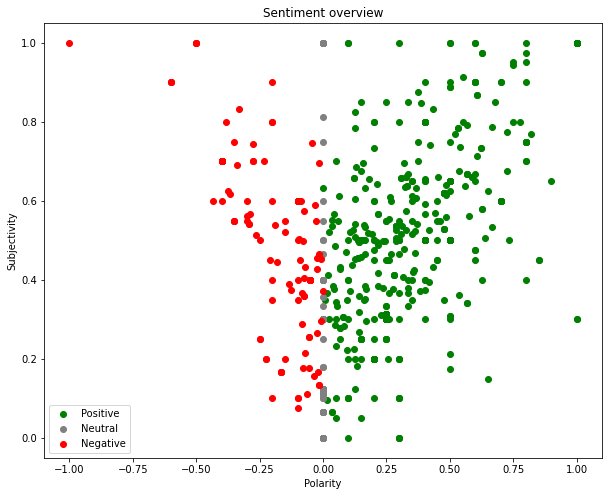

In [15]:
# Plotting 
plt.figure(figsize=(10,8)) 

plt.scatter(post_twt["Polarity"], post_twt["Subjectivity"], color='green', label='Positive') 
plt.scatter(neu_twt["Polarity"], neu_twt["Subjectivity"], color='grey', label='Neutral') 
plt.scatter(neg_twt["Polarity"], neg_twt["Subjectivity"], color='red', label='Negative') 
# plt.scatter(x,y,color)   
plt.title('Sentiment overview') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.legend()
plt.show()

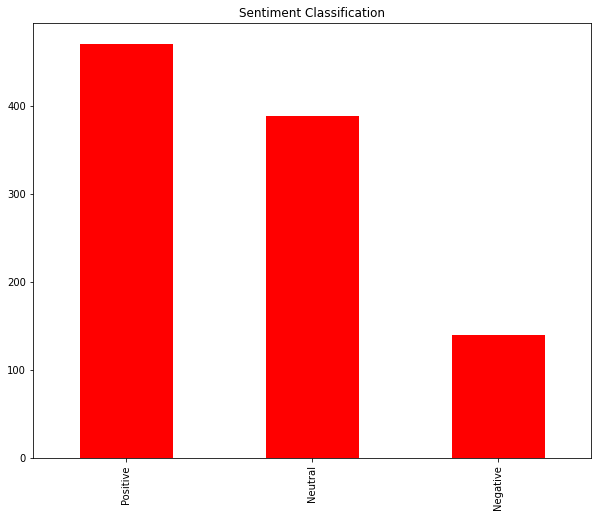

In [16]:
# let's see how ratio of sentiment
# Plotting 
plt.figure(figsize=(10,8)) 
df.Sentiment.value_counts().plot(kind='bar', color='red')
plt.title('Sentiment Classification')
plt.show()

In [17]:
# let's see the percentage of different sentiment's class
# calculating percentage
ratio = pd.DataFrame(df.Sentiment.value_counts(normalize=True)*100)
ratio['Total'] = df.Sentiment.value_counts()
ratio

,Sentiment,Total
Positive,47.1,471
Neutral,38.9,389
Negative,14.0,140


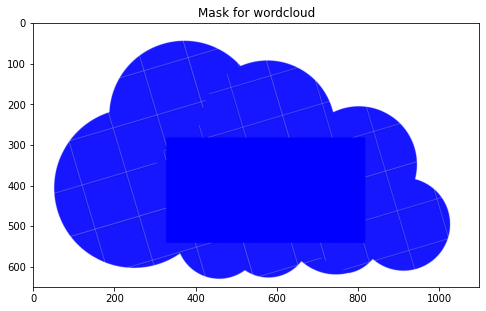

In [18]:
# all words of tweets
allWords = ' '.join([twts for twts in df['Tweets']])

# image we will use for Word's cloud mask
bitcoin = cv2.imread('/content/c2.png')
plt.figure(figsize=(8,6))
plt.imshow(bitcoin)
plt.title('Mask for wordcloud')
plt.show()

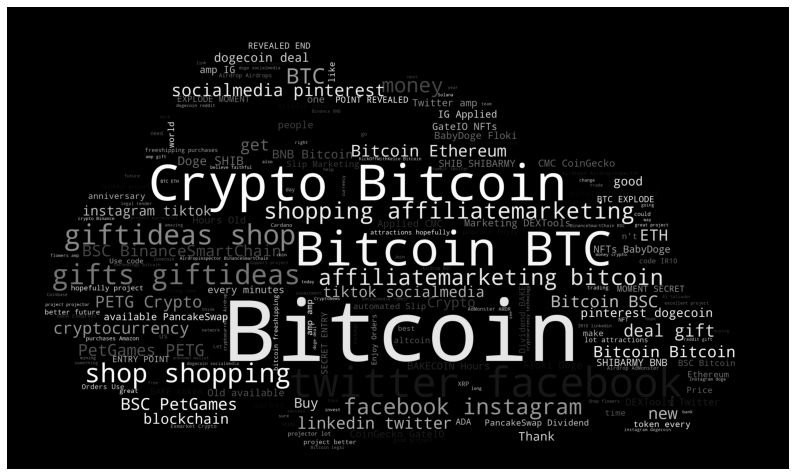

In [19]:
# word cloud
Word_cloud(data=allWords, stop_words=stpwrd_punc, figsize=(14, 9), mask=bitcoin)